```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 3.1.1.2. in https://scikit-learn.org/stable/modules/cross_validation.html
2. https://scikit-learn.org/stable/modules/grid_search.html#grid-search
3. https://github.com/STAC-IITMandi/Exoplanet-Detection/blob/master/live-953-2037-jair.pdf
4. https://github.com/vaasha/Machine-leaning-in-examples/blob/master/sklearn/cross-validation/Cross%20Validation.ipynb
```

# Cross-Validation (CV)

## Table of Contents

- [Cross Validation Techniques](#tech)
- [Cross-validation on Imbalanced Data](#imb)
- [XXX](#report)

## Introduction

**[Cross validation (CV)](https://en.wikipedia.org/wiki/Cross-validation_(statistics))**, sometimes called `rotation estimation` or `out-of-sample testing` is an essential tool in statistical learning to estimate the performance of your algorithm (how the results of a statistical analysis will generalize to an independent dataset). Despite its great power it also exposes some fundamental risk when done wrong which may terribly bias your performance estimate.

During cross-validation, we are typically trying to understand how well our model can generalize, and how well it can predict our outcome of interest on unseen samples.

**Cross validation** involves splitting the training dataset of observations into k non overlapping groups (or folds) of approximately equal size. One fold is treated as a validation set, and the machine learning algorithm is trained on the remaining k-1 folds. The mean squared error - MSE -  (or another metric) is then computed on the validation fold. This procedure is repeated k times; each time, a different group of observations is treated as a validation set.

<img src="images/cross_validation_kfold.png" alt="" style="width: 600px;"/>

This process results in k estimates of the MSE quantity, namely MSE1, MSE2, ...MSEk. The cross validation estimate for the MSE is then computed by simply averaging these values:

<img src="images/cross_validation_mse.png" alt="" style="width: 400px;"/> 

This value is an estimate, say MSE_hat, of the real MSE and our goal is to make this estimate as accurate as possible. MSE is just one for the possible metrics you can estimate using cross validation. **The evaluation metrics should always report on generalization performance.** For more, see [sklearn implementation of CV](https://scikit-learn.org/stable/modules/cross_validation.html).

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset,
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, RepeatedKFold

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

---
<a id='tech'></a>

## Cross Validation Techniques
see TODO

### K-fold
TODO

### Repeated K-Fold
[RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold) repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [5]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
random_state = 12883823
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
for train, test in cv.split(X):
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]
[0 2] [1 3]
[1 3] [0 2]


### Leave One Out (LOO)
[LeaveOneOut (or LOO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for  samples, we have  different training sets and  different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set:

In [6]:
from sklearn.model_selection import LeaveOneOut

X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


### Leave P Out (LPO)
TODO

### Random permutations cross-validation a.k.a. Shuffle & Split
TODO

### Stratified k-fold
TODO

---
<a id='imb'></a>

## Cross-validation on Imbalanced Data

Let’s now have a look at one of the most typical mistakes when using cross validation. When cross validation is done wrong its result does not reflect reality. In other words, you may think that you just found a perfect machine learning algorithm with incredibly good performance metric, while in reality you simply wrongly applied CV by introduction `knowledge leaking` or `data leaking`.

There is a major issue in most clinical research, i.e. how to properly cross-validate when we have imbalanced data. As a matter of fact, in the context of many medical applications, we have datasets where we have two classes for the main outcome; normal samples and relevant samples. For example in a cancer detection application we might have a small percentages of patients with cancer (relevant samples) while the majority of samples might be healthy individuals. Outside of the medical space, this is true (even more) for the case for example of fraud detection, where the rate of relevant samples (i.e. frauds) to normal samples might be even in the order of 1 to 100 000.

Typically, classifiers are more sensitive to detecting the majority class and less sensitive to the minority class. Thus, if we don't take care of the issue, the classification output will be biased, in many cases resulting in always predicting the majority class. 

**What can we do when we have imbalanced data?** Mainly three things:
- **Ignoring the problem.** Building a classifier using the data as it is, would in most cases give us a prediction model that always returns the majority class. The classifier would be biased.
- **Undersampling the majority class.** Simply select n samples at random from the majority class, where n is the number of samples for the minority class, and use them during training phase, after excluding the sample to use for validation.
- **Oversampling the minority class.** The easiest way to oversample is to re-sample the minority class, i.e. to duplicate the entries, or manufacture data which is similar to the data what we have already.

### Oversampling the Minority Class

**Oversampling the minority class can result in overfitting problems if we oversample before cross-validating.** What is wrong with oversampling before cross-validating? Let’s consider the simplest oversampling method ever, as an example that clearly explains this point.

The easiest way to oversample is to re-sample the minority class, i.e. to duplicate the entries, or manufacture data which is exactly the same as what we have already. Now, if we do so before cross-validating, i.e. before we enter the leave one participant out cross-validation loop, we will be training the classifier using n-1 entries, leaving 1 out, but including in the n-1 one or more instances that are exactly the same as the one being validated. Thus, defeating the purpose of cross-validation altogether. Let's have a look at this issue graphically:

<img src="images/cross-validation1.jpg" alt="" style="width: 400px;"/>

From left to right, we start with the original dataset where we have a minority class with two samples. We duplicate those samples, and then we do cross-validation. At this point there will be iterations, such as the one showed, where the training and validation set contain the same sample, resulting in overfitting and misleading results. Here is how this should be done:

<img src="images/cross-validation2.jpg" alt="" style="width: 400px;"/>

First, we start cross-validating. This means that at each iteration we first exclude the sample to use as validation set, and then oversample the remaining of the minority class (in orange). In this toy example we had only two samples, so we created three instances of the same. `The difference from before, is that clearly now we are not using the same data for training and validation.` Therefore we will obtain more representative results. The same holds even if we use other cross-validation and oversampling methods, such as k-fold cross-validation or SMOTE.

This was a simple example, and better methods can be used to oversample. One of the most common being the `SMOTE` technique, i.e. a method that instead of simply duplicating entries creates entries that are interpolations of the minority class, as well as undersamples the majority class. Normally when we duplicate data points the classifiers get very convinced about a specific data point with small boundaries around it, as the only point where the minority class is valid, instead of generalizing from it. However, `SMOTE` effectively forces the decision region of the minority class to become more general, partially solving the generalization problem. There are some pretty neat visualizations in the original paper, so I would advice to have a look [here](https://github.com/STAC-IITMandi/Exoplanet-Detection/blob/master/live-953-2037-jair.pdf). 

However, something to keep in mind is that while oversampling using SMOTE does improve the decision boundaries, it has nothing to do with cross-validation. If we use the same data for training and validation, results will be dramatically better than what they would be with out of sample data. The same problem that we highlighted above with a simpler example, is still present in more robust scenarios. Let’s see what results we can get when oversampling before cross-validation.

#### Datasets
We will use two datasets as an example (one synthethic, one real) to demonstrate the difference of doing oversampling before or during cross-validation.

##### Dataset 1

In [7]:
# target = 'class'
df = get_dataset('pima-indians-diabetes')
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df["class"].value_counts(dropna=False)

0    500
1    268
Name: class, dtype: int64

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


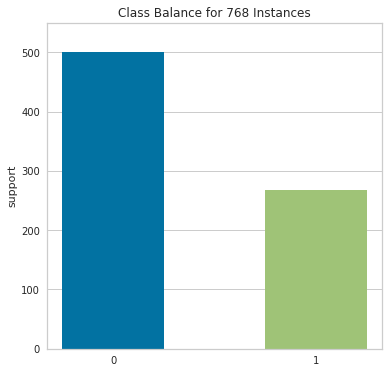

<AxesSubplot:title={'center':'Class Balance for 768 Instances'}, ylabel='support'>

In [9]:
from yellowbrick.classifier import ClassBalance

fig, ax = plt.subplots(figsize=(6, 6))
cb_viz = ClassBalance(labels=["0", "1"])
cb_viz.fit(df["class"].values.reshape(-1, 1).flatten())
cb_viz.poof()
#fig.savefig("images/class_balance.png", dpi=300)

In [10]:
# Show percent of missing values per column
df.isnull().mean() * 100

preg     0.0
plas     0.0
pres     0.0
skin     0.0
test     0.0
mass     0.0
pedi     0.0
age      0.0
class    0.0
dtype: float64

In [11]:
y1 = df["class"]
X1 = df.drop(columns='class')
y1.value_counts(dropna=False)

0    500
1    268
Name: class, dtype: int64

##### Dataset 2

In [12]:
from sklearn.datasets import make_classification

# Define dataset with 1,000 examples and 10 input features, 
# five of which are important and five of which are redundant
# and impalanced binary class (9:1 ratio) as target
X2, y2 = make_classification(n_samples=1000, 
                           n_features=10, 
                           n_informative=5, 
                           n_redundant=5, 
                           random_state=1, 
                           weights=[.9])
# summarize the dataset
print(X2.shape, y2.shape)
pd.Series(y2).value_counts(dropna=False)

(1000, 10) (1000,)


0    897
1    103
dtype: int64

#### Bad cross-validation when oversampling
Here is the code, we first oversample then we go into the cross-validation loops. :

In [13]:
# Train test split for dataset 1
X = X1
y = y1

In [18]:
# Train test split for dataset 2
X = X2
y = pd.Series(y2)

In [19]:
# Use this method or the method below
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

In [ ]:
# Use this method or the method above
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=42)
X, y = oversample.fit_sample(X, y)

In [20]:
y.value_counts(dropna=False)

1    897
0    897
dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1255, 10) (539, 10) (1255,) (539,)


In [22]:
# Cross-validation

for model in [
    #DummyClassifier,
    #LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
    
    cls = model()
    #cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    #cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    #cv = ShuffleSplit(n_splits=5, random_state=42)
    #scores = cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=cv)
    scores = cross_val_score(cls, X_train, y_train, scoring="f1", cv=cv)

    print(f"{model.__name__:22}  F1-score: "
          f"{scores.mean():.3f} STD: {scores.std():.2f} ")
    
# Other scoring params: 
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

DecisionTreeClassifier  F1-score: 0.937 STD: 0.02 
KNeighborsClassifier    F1-score: 0.944 STD: 0.01 
GaussianNB              F1-score: 0.737 STD: 0.03 
SVC                     F1-score: 0.940 STD: 0.01 
RandomForestClassifier  F1-score: 0.976 STD: 0.01 
XGBClassifier           F1-score: 0.977 STD: 0.01 


```
DATASET 1 (SMOTE)
---------
DecisionTreeClassifier  F1-score: 0.706 STD: 0.05 
KNeighborsClassifier    F1-score: 0.725 STD: 0.03 
GaussianNB              F1-score: 0.719 STD: 0.02 
SVC                     F1-score: 0.687 STD: 0.03 
RandomForestClassifier  F1-score: 0.782 STD: 0.03 
XGBClassifier           F1-score: 0.756 STD: 0.03
        
DATASET 2 (SMOTE)
---------
DecisionTreeClassifier  F1-score: 0.937 STD: 0.02 
KNeighborsClassifier    F1-score: 0.944 STD: 0.01 
GaussianNB              F1-score: 0.737 STD: 0.03 
SVC                     F1-score: 0.940 STD: 0.01 
RandomForestClassifier  F1-score: 0.976 STD: 0.01 
XGBClassifier           F1-score: 0.977 STD: 0.01 
```

Results are pretty good now. Especially for the dataset 2 (which is extremely imbalanced), we obtained F1-score close to 1 without any feature engineering, simply using what was provided in the dataset, and without any parameter tuning for the classifier. Once again, apart from the differences in the two oversampling methods (replication of the minority class or SMOTE), `the issue here is not even which method to use, but when to use it`. Using oversampling before cross-validation we have now obtained very good F1-score, i.e. we `overfitted`. 

#### Proper cross-validation when oversampling
The way to proper cross validate when oversampling data is rather simple, **we should oversample inside the loop**. It makes no sense to create instances based on our current minority class and then exclude an instance for validation, pretending we didn’t generate it using data that is still in the training set. This time we oversample inside the cross-validation loop, after the validation sample has already been removed from the training data, so that we create synthetic data by interpolating only recordings that will not be used for validation.

In [23]:
# Train test split for dataset 1
X = X1
y = y1

In [28]:
# Train test split for dataset 2
X = pd.DataFrame(X2)
y = pd.Series(y2)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(700, 10) (300, 10) (700,) (300,)


In [30]:
from sklearn.metrics import f1_score

for model in [
    #DummyClassifier,
    #LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    fold_count = 0

    for train, val in cv.split(X_train, y_train):
        #print(f"Processing fold {fold_count}")

        # Select df rows based on list index
        X_train_fold = X_train.iloc[train]
        X_val_fold = X_train.iloc[val]

        y_train_fold = y_train.iloc[train]
        y_val_fold = y_train.iloc[val]

        # Oversample technique 1
        oversample = SMOTE(random_state=42)
        X_train_fold, y_train_fold = oversample.fit_resample(X_train_fold, y_train_fold)
        #print(y_train_fold.value_counts(dropna=False))

        # Oversample technique 2
        #oversample = RandomOverSampler(random_state=42)
        #X_train_fold, y_train_fold = oversample.fit_sample(X_train_fold, y_train_fold)

        # Train
        cls = model()
        cls.fit(X_train_fold, y_train_fold)

        # Predict & score
        pred = cls.predict(X_val_fold)
        scores.append(f1_score(y_val_fold, pred))

        fold_count += 1
        
    scores = pd.Series(scores)

    print(f"{model.__name__:22}  F1-score: "
          f"{scores.mean():.3f} STD: {scores.std():.2f} ")

DecisionTreeClassifier  F1-score: 0.581 STD: 0.07 
KNeighborsClassifier    F1-score: 0.634 STD: 0.04 
GaussianNB              F1-score: 0.368 STD: 0.08 
SVC                     F1-score: 0.681 STD: 0.07 
RandomForestClassifier  F1-score: 0.655 STD: 0.11 
XGBClassifier           F1-score: 0.709 STD: 0.11 


```
DATASET 1 (SMOTE)
---------
DecisionTreeClassifier  F1-score: 0.554 STD: 0.04 
KNeighborsClassifier    F1-score: 0.600 STD: 0.05 
GaussianNB              F1-score: 0.654 STD: 0.05 
SVC                     F1-score: 0.633 STD: 0.03 
RandomForestClassifier  F1-score: 0.668 STD: 0.06 
XGBClassifier           F1-score: 0.626 STD: 0.04
        
DATASET 2 (SMOTE)
---------
DecisionTreeClassifier  F1-score: 0.581 STD: 0.07 
KNeighborsClassifier    F1-score: 0.634 STD: 0.04 
GaussianNB              F1-score: 0.368 STD: 0.08 
SVC                     F1-score: 0.681 STD: 0.07 
RandomForestClassifier  F1-score: 0.655 STD: 0.11 
XGBClassifier           F1-score: 0.709 STD: 0.11 
```

As expected, more data didn't solve any problem, regardless of doing "smart" oversampling using SMOTE. What did bring very high accuracy, was simply overfitting. `In the second approach, we not only get lower F1-scores but also higher standard deviations.`

To summarize, **when cross-validating with oversampling**, do the following to make sure your results are generalizable:
- Inside the cross-validation loop, get a sample out and do not use it for anything related to features selection, oversampling or model building.
- Oversample your minority class, without the sample you already excluded.
- Use the excluded sample for validation, and the oversampled minority class and the majority class, to create the model.
- Repeat n times, where n is your number of samples (if doing leave one participant out cross-validation).